# Логические методы классификации

In [1]:
import warnings
warnings.filterwarnings("ignore")

### Задание на синтетичеких одномерных данных

Сгенерируйте одномерные данные.

Разделите свою выборку на train и test

Обучите дерево на ваших данных и добавьте визуализацию. Напишите, как дерево принимало решение в каждом узле.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split

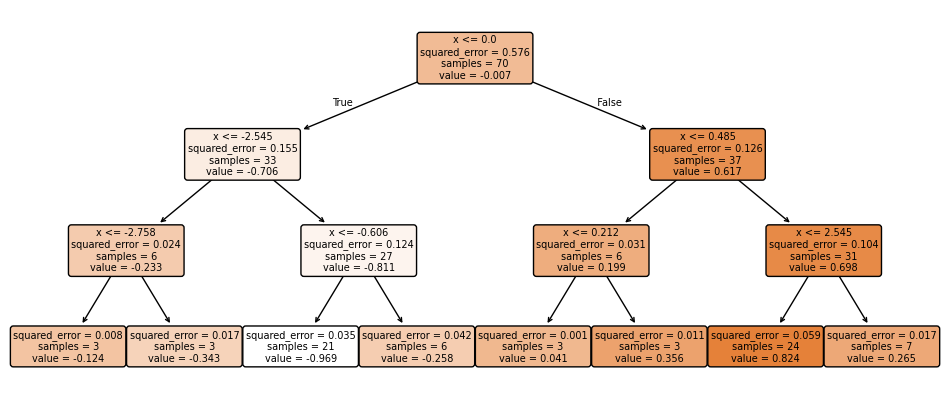

In [3]:
np.random.seed(42)
X = np.linspace(-3, 3, 100).reshape(-1, 1)
y = np.sin(X).ravel() + np.random.normal(0, 0.2, X.shape[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = DecisionTreeRegressor(max_depth=3, random_state=42)
model.fit(X_train, y_train)

plt.figure(figsize=(12, 5))
plot_tree(model, feature_names=["x"], filled=True, rounded=True)
plt.show()